In [ ]:
#@title Clone and install our Quadruped RL package
!git clone https://github.com/alexeiplatzer/unitree-go2-mjx-rl.git
!pip install -e unitree-go2-mjx-rl

In [2]:
!pip show jax

Name: jax
Version: 0.5.2
Summary: Differentiate, compile, and transform Numpy code.
Home-page: https://github.com/jax-ml/jax
Author: JAX team
Author-email: jax-dev@google.com
License: Apache-2.0
Location: /usr/local/lib/python3.12/dist-packages
Requires: jaxlib, ml_dtypes, numpy, opt_einsum, scipy
Required-by: chex, dopamine_rl, flax, mujoco-mjx, optax, orbax-checkpoint, quadruped_mjx_rl


In [ ]:
#@title Refresh the package if any necessary changes have been pushed. Important in development
repo_path = "./unitree-go2-mjx-rl"
!git -C {repo_path} pull

INFO:root:Logging switched on.


Setting environment variable to use GPU rendering:
env: MUJOCO_GL=egl


INFO:OpenGL.acceleratesupport:No OpenGL_accelerate module loaded: No module named 'OpenGL_accelerate'


[[FlatTile(color=Color(r=0.46, g=0.362, b=0.216, a=1.0), square_side=2.0, floor_thickness=0.05), FlatTile(color=Color(r=0.46, g=0.362, b=0.216, a=1.0), square_side=2.0, floor_thickness=0.05), FlatTile(color=Color(r=0.46, g=0.362, b=0.216, a=1.0), square_side=2.0, floor_thickness=0.05), FlatTile(color=Color(r=0.46, g=0.362, b=0.216, a=1.0), square_side=2.0, floor_thickness=0.05), FlatTile(color=Color(r=0.46, g=0.362, b=0.216, a=1.0), square_side=2.0, floor_thickness=0.05), FlatTile(color=Color(r=0.46, g=0.362, b=0.216, a=1.0), square_side=2.0, floor_thickness=0.05)]]


""

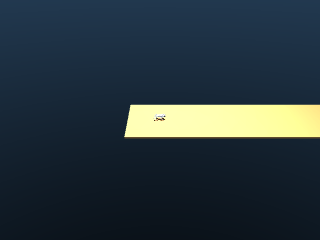

Setup finished, initializing the environment...


INFO:2025-09-08 12:57:35,198:jax._src.xla_bridge:924: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-09-08 12:57:35,204:jax._src.xla_bridge:924: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:root:Using JAX default device: cuda:0.
INFO:root:MJX Warp is disabled via MJX_WARP_ENABLED=false.
INFO:root:Using JAX default device: cuda:0.
INFO:root:MJX Warp is disabled via MJX_WARP_ENABLED=false.
INFO:root:Params restored, starting training...
INFO:root:Device count: 1, process count: 1 (id 0), local device count: 1, devices to be used co

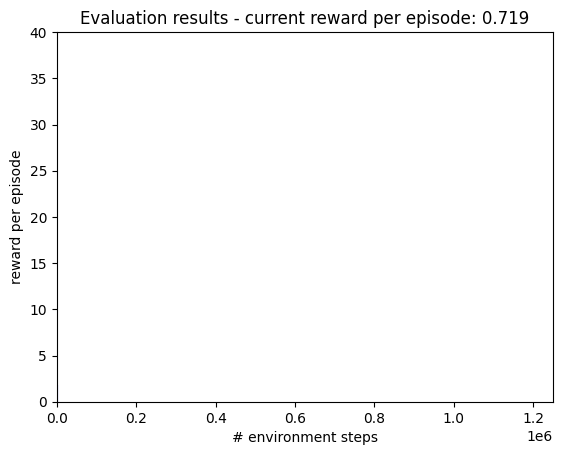

INFO:root:Setup took 29.470953702926636
INFO:root:Using JAX default device: cuda:0.
INFO:root:MJX Warp is disabled via MJX_WARP_ENABLED=false.
INFO:root:eval/episode_reward: 0.71909726
INFO:root:eval/episode_reward_std: 1.1319388
INFO:root:current_step: 0
INFO:root:starting iteration 0 128.79549431800842


XlaRuntimeError: INVALID_ARGUMENT: layout minor_to_major field contains 1 elements, but shape is rank 0: {0}; shape: element_type: S32 layout { tail_padding_alignment_in_elements: 1 }

In [1]:
#@title Session setup

# Configure logging
import logging
logging.basicConfig(level=logging.INFO, force=True)
logging.info("Logging switched on.")

# Check if MuJoCo installation was successful
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
    raise RuntimeError(
        'Cannot communicate with GPU. '
        'Make sure you are using a GPU Colab runtime. '
        'Go to the Runtime menu and select Choose runtime type.'
    )

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
    with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
        f.write("""{
        "file_format_version" : "1.0.0",
        "ICD" : {
            "library_path" : "libEGL_nvidia.so.0"
        }
    }
    """)

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

# Tell XLA to use Triton GEMM, this improves steps/sec by ~30% on some GPUs
xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags

# More legible printing from numpy.
import numpy as np
np.set_printoptions(precision=3, suppress=True, linewidth=100)

# Prepare paths
from etils.epath import Path
repo_path = Path("unitree-go2-mjx-rl")
configs_path = repo_path / "configs"
scenes_path = repo_path / "resources" / "unitree_go2"
results_path = Path("results")
results_path.mkdir(parents=True, exist_ok=True)

# Prepare configs
from quadruped_mjx_rl.robots import predefined_robot_configs
robot_config = predefined_robot_configs["unitree_go2"]()

from quadruped_mjx_rl.environments import JoystickBaseEnvConfig
env_config = JoystickBaseEnvConfig()

from quadruped_mjx_rl.models import ActorCriticConfig
model_config = ActorCriticConfig(
    modules = ActorCriticConfig.ModulesConfig(
        policy=[128, 128, 128, 128],
        value=[256, 256, 256, 256],
    ),
)

from quadruped_mjx_rl.training.configs import TrainingConfig
training_config = TrainingConfig(num_timesteps=1_000_000, num_envs=2048, num_eval_envs=2048, batch_size=256)

# Set up the terrain
init_scene_path = scenes_path / "scene_mjx_empty_arena.xml"

from quadruped_mjx_rl.environments.physics_pipeline import load_to_spec, spec_to_model
from quadruped_mjx_rl.terrain_gen.obstacles import FlatTile, StripesTile
from quadruped_mjx_rl.terrain_gen.tile import TerrainConfig
flat_tile = FlatTile()
stripes_tile = StripesTile()
terrain = TerrainConfig(tiles=[[flat_tile] * 6])
print(terrain.tiles)
env_spec = load_to_spec(init_scene_path)
terrain.make_arena(env_spec)
env_model = spec_to_model(env_spec)

# Prepare initial position
x, y, z_offset = terrain.get_tile_center_qpos(0, 0)
init_qpos = env_model.keyframe("home").qpos
init_qpos[0] = x
init_qpos[1] = y
init_qpos[2] += z_offset

# Render the situation
import mujoco
from quadruped_mjx_rl.environments.rendering import show_image
camera = mujoco.MjvCamera()
mujoco.mjv_defaultCamera(camera)
camera.lookat = [0, 0, 0]
camera.distance = 18
camera.elevation = -30
mj_data = mujoco.MjData(env_model)
mj_data.qpos = init_qpos
with mujoco.Renderer(env_model) as renderer:
    mujoco.mj_forward(env_model, mj_data)
    renderer.update_scene(mj_data, camera=camera)
    image = renderer.render()
show_image(image)


from quadruped_mjx_rl.environments import resolve_env_class, get_env_factory
env_class = resolve_env_class(env_config)
env_model = env_class.customize_model(env_model, env_config)
env_factory = get_env_factory(
    robot_config=robot_config,
    environment_config=env_config,
    env_class=env_class,
    env_model=env_model,
)

# Create the environment
print("Setup finished, initializing the environment...")
env = env_factory()
eval_env = env_factory()

# Checkpointing
from quadruped_mjx_rl.models.io import save_params, load_params
# restore_params = load_params(results_path / "resulting_params")
logging.info("Params restored, starting training...")

# Try to launch a vision policy training
from quadruped_mjx_rl.training.train_interface import train
params = train(
    training_config=training_config,
    model_config=model_config,
    training_env=env,
    evaluation_env=eval_env,
    # restore_params=restore_params,
)

save_params(results_path / "resulting_params", params)